In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [4]:
main_path = "/kaggle/input"

paths = []
labels = []

for dirname, _, filenames in os.walk(main_path):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split(".")[0]
    labels.append(label.lower())

print("Dataset is loaded.")


Dataset is loaded.


In [5]:
# Creating Dataframe
data_df = pd.DataFrame()
data_df['speech_paths'] = paths
data_df['labels'] = labels
data_df['labels'] = data_df['labels'].astype('category')
data_df.head()


,speech_paths,labels
0,/kaggle/input/happyyy/happy.opus,happy
1,/kaggle/input/sad123/sad.opus,sad
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [6]:
len(paths)

5602

In [7]:
data_df['labels'].value_counts()

labels
happy      801
sad        801
angry      800
disgust    800
fear       800
neutral    800
ps         800
Name: count, dtype: int64

In [8]:
def waveplotting(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(data, sr=sr)
  plt.title(emotion, size=10)
  plt.show()

def spectrogram(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  D = librosa.amplitude_to_db(abs(librosa.stft(data)))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title(emotion, size=10)
  plt.show()

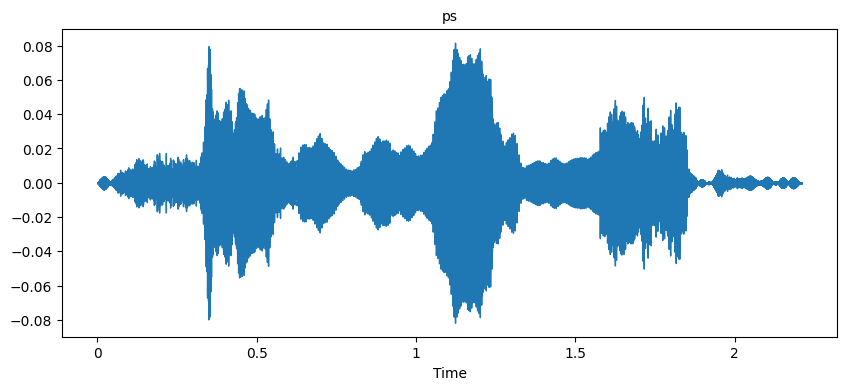

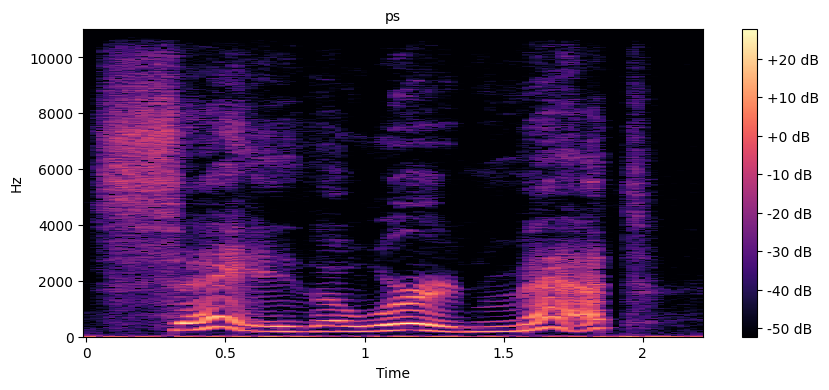

In [9]:
emotion = 'ps'
path = data_df['speech_paths'][data_df['labels'] == emotion].values[0]
data, sr = librosa.load(path)
waveplotting(data, sr, emotion)
spectrogram(data, sr, emotion)
Audio(path)

In [10]:
def extract_mfcc(filename):
  data, sr = librosa.load(filename, duration=3, offset=0.5)
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

extract_mfcc(path)

array([-5.0183969e+02,  1.1431044e+02,  4.0522842e+00, -5.1728482e+00,
        6.6190042e+00,  7.0010509e+00, -2.2147770e+01, -4.4756227e+00,
       -1.6525053e+01, -4.2487702e-01, -7.4836311e+00, -8.0635042e+00,
       -1.5284193e+00, -2.3743765e+00, -6.4739311e-01,  2.2440813e+00,
       -1.1893580e+00,  7.1265912e+00,  5.8106834e-01, -2.5696900e+00,
        9.2224485e-01, -2.2434852e+00,  1.7982355e+00,  4.6595111e+00,
       -3.3933809e+00,  3.2739587e+00, -9.5608932e-01,  3.7836039e+00,
        4.5111408e+00,  5.2651901e+00,  4.9775386e+00,  5.1978498e+00,
        4.2810898e+00,  4.8004689e+00,  1.0270661e+01,  1.3471785e+01,
        1.4662754e+01,  1.7248032e+01,  1.2077934e+01,  8.4905176e+00],
      dtype=float32)

In [11]:
X_mfcc = data_df['speech_paths'].apply(lambda x: extract_mfcc(x))
x_mfcc = np.array([x for x in X_mfcc])
x_mfcc.shape

(5602, 40)

In [12]:
# For LSTM model, expanding dimentions
x = np.expand_dims(x_mfcc, axis=2)
x.shape

(5602, 40, 1)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(data_df['labels']).reshape(-1,1)).toarray()
y.shape

(5602, 7)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(LSTM(123, return_sequences=False, input_shape=(40, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense (Dense)               (None, 64)                7936      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 71747 

In [15]:
model.fit(x, y, 
          epochs=100, 
          batch_size=512, 
          validation_split=0.2, 
          shuffle = True)

Epoch 1/100
9/9 [==============================] - 7s 351ms/step - loss: 1.8795 - accuracy: 0.3412 - val_loss: 2.0095 - val_accuracy: 0.1106
Epoch 2/100
9/9 [==============================] - 2s 255ms/step - loss: 1.6516 - accuracy: 0.5168 - val_loss: 1.9971 - val_accuracy: 0.1079
Epoch 3/100
9/9 [==============================] - 2s 253ms/step - loss: 1.2762 - accuracy: 0.6289 - val_loss: 1.8561 - val_accuracy: 0.1142
Epoch 4/100
9/9 [==============================] - 2s 255ms/step - loss: 0.8908 - accuracy: 0.6996 - val_loss: 1.4538 - val_accuracy: 0.2489
Epoch 5/100
9/9 [==============================] - 2s 252ms/step - loss: 0.6459 - accuracy: 0.7612 - val_loss: 1.1271 - val_accuracy: 0.6111
Epoch 6/100
9/9 [==============================] - 2s 263ms/step - loss: 0.4709 - accuracy: 0.8402 - val_loss: 0.8025 - val_accuracy: 0.7368
Epoch 7/100
9/9 [==============================] - 2s 260ms/step - loss: 0.3751 - accuracy: 0.8793 - val_loss: 0.5299 - val_accuracy: 0.8260
Epoch 8/100
9

In [21]:
from IPython.display import Audio

# Replace 'filename.mp3' with the actual filename from your dataset
file_path = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_bath_ps.wav'

Audio(file_path)


In [20]:
# Example code for predicting emotions for test data

# Extract MFCC features for test data
test_path = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_bar_ps.wav'  # Replace with the path to your test audio file
test_mfcc = extract_mfcc(test_path)  # Extract MFCC features for the test audio
test_input = np.expand_dims(test_mfcc, axis=0)  # Expand dimensions to match model input

# Predict emotions for test data
predictions = model.predict(test_input)  # Use the trained model to predict emotions

# Decode predictions to get the predicted emotion
predicted_emotion_index = np.argmax(predictions)  # Get index of highest probability
predicted_emotion = encoder.categories_[0][predicted_emotion_index]  # Decode index to emotion label

print("Predicted Emotion:", predicted_emotion)


1/1 [==============================] - 0s 33ms/step
Predicted Emotion: ps
